In [1]:
import pandas as pd
import time

max_seq_length=30
embedding_dim=300
batch_zise=64
epoch_szie=200

train_csv='MSRTrainData.csv'

df=pd.read_csv(train_csv, error_bad_lines=False)
print(len(df.index))
X=df[['Sentence1','Sentence2']]
Y=df['Score']

from gensim.parsing.preprocessing import remove_stopwords , preprocess_string
from gensim.models import Word2Vec

word_tokens=[]
for index, row in df.iterrows():
    try:
        temp1=preprocess_string( remove_stopwords(row['Sentence1']))
        temp2=preprocess_string( remove_stopwords(row['Sentence2']))
        word_tokens.append(temp1)
        word_tokens.append(temp2)
    except:
        continue
    
print(word_tokens[0],len(word_tokens))

word_model = Word2Vec(word_tokens, size=embedding_dim, window=5, min_count=1, workers=4)
word_model.save('MetaData/'+"Word2Vec.model")
word_model = Word2Vec.load("MetaData/"+"Word2Vec.model")
vocab_size=len(word_model.wv.vocab)
print(vocab_size)


from keras.preprocessing.sequence import pad_sequences
import numpy as np
x1=[]
x2=[]
shap=(30,300)
for index, row in df.iterrows():
    sentence1=row['Sentence1']
    sentence2=row['Sentence2']
    try:
        tokens1=preprocess_string( remove_stopwords(sentence1) )
        tokens2=preprocess_string( remove_stopwords(sentence2) )
        if tokens1==[]:tokens1=['print']
        if tokens2==[]:tokens2=['print']
        vec_matrix1=[]
        for word in tokens1:
            vec=0
            try:vec=word_model.wv[word]
            except:
                vec=np.random.rand(300)
                print('ex',end='')
            vec_matrix1.append(vec)
        vec_matrix2=[]
        for word in tokens2:
            vec=0
            try:vec=word_model.wv[word]
            except:
                vec=np.random.rand(300)
                print('ex',end='')
            vec_matrix2.append(vec)
        temp1=[vec_matrix1]
        temp2=[vec_matrix2]

        try:
            pad_vec_matrix1=pad_sequences(temp1, padding='post', truncating='post', maxlen=30 ,dtype='float64')
            if np.shape(pad_vec_matrix1[0])== shap:x1.append(pad_vec_matrix1[0])
            else:print('error at',index)
            pad_vec_matrix2=pad_sequences(temp2, padding='post', truncating='post', maxlen=30 ,dtype='float64')
            if np.shape(pad_vec_matrix1[0])== shap:x2.append(pad_vec_matrix2[0])
            else:print('error at',index)

        except:
            print('ex',end='')
            continue
    except Exception as e:
        print(e,index,'\n',sentence1,'\n',sentence2,end='\n\n')

print(len(x1),len(x1[1]),len(x1[1][1]))
print(len(x2),len(x2[1]),len(x2[1][1]))

b'Skipping line 1127: expected 4 fields, saw 5\n'


1470


unable to import 'smart_open.gcs', disabling that module


['problem', 'like', 'mean', 'correct', 'chang', 'shuttl', 'fleet', 'start', 'fly'] 2940
5229


Using TensorFlow backend.


1470 30 300
1470 30 300


In [4]:
import keras.backend as K
from keras.layers import Layer
class ManDist(Layer):
    """
    Keras Custom Layer that calculates Manhattan Distance.
    """

    # initialize the layer, No need to include inputs parameter!
    def __init__(self, **kwargs):
        self.result = None
        super(ManDist, self).__init__(**kwargs)

    # input_shape will automatic collect input shapes to build layer
    def build(self, input_shape):
        super(ManDist, self).build(input_shape)

    # This is where the layer's logic lives.
    def call(self, x, **kwargs):
        self.result = K.exp(-K.sum(K.abs(x[0] - x[1]), axis=1, keepdims=True))
        return self.result

    # return output shape
    def compute_output_shape(self, input_shape):
        return K.int_shape(self.result)

In [5]:
from keras.layers import Conv1D, MaxPooling1D, Input , Embedding , LSTM , Permute ,RepeatVector , Concatenate , Dense
from keras.models import Model , Sequential , load_model
from keras.optimizers import Adadelta
import keras.backend.tensorflow_backend as tb
from keras.utils import plot_model

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 30, 300)      0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 30, 48)       14448       input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 30, 48)       14448       input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 30, 64)       9280        conv1d_4[0][0]                   
____________________________________________________________________________________________

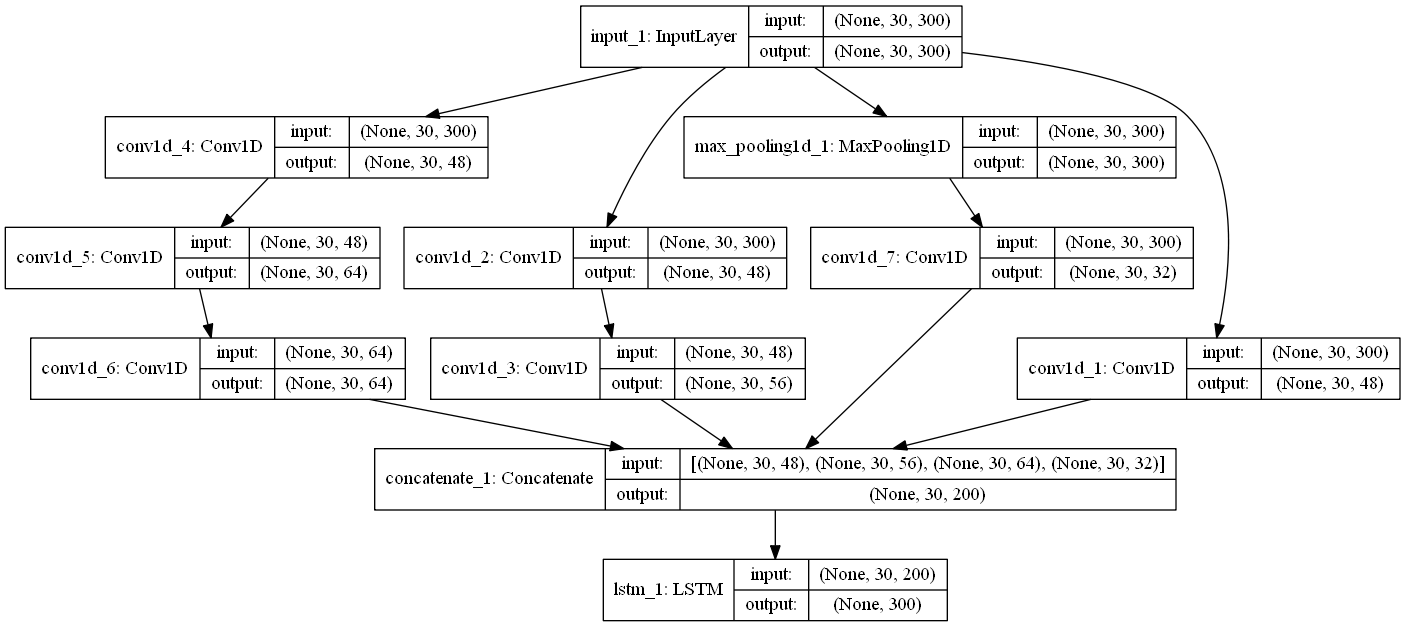

In [6]:
input_1 = Input(shape = (max_seq_length, embedding_dim))
#input_1=Embedding(input_dim=len(embeddings),output_dim=embedding_dim,input_length=max_seq_lenght)#,weights=[embeddings], input_shape=(max_seq_length,), trainable=False)

en_tower_1 = Conv1D(48, (1), padding='same', activation='relu')(input_1)

en_tower_2=  Conv1D(48, (1), padding='same', activation='relu')(input_1)
en_tower_2=  Conv1D(56, (3), padding='same', activation='relu')(en_tower_2)

en_tower_3=  Conv1D(48, (1), padding='same', activation='relu')(input_1)
en_tower_3=  Conv1D(64, (3), padding='same', activation='relu')(en_tower_3)
en_tower_3=  Conv1D(64, (3), padding='same', activation='relu')(en_tower_3)

en_tower_4=  MaxPooling1D((2), strides=(1), padding='same')(input_1)
en_tower_4=  Conv1D(32, (1), padding='same', activation='relu')(en_tower_4)

concat_1= Concatenate(axis = 2)([en_tower_1, en_tower_2,en_tower_3,en_tower_4])
#encoder_inception_model=Model(inputs=input_1, outputs=concat_1)

#encoder_inception_model.summary()

lstm_encode=LSTM((embedding_dim),activation='tanh')(concat_1)
rep=RepeatVector(max_seq_length)(lstm_encode)
input_2=LSTM((embedding_dim),activation='tanh',return_sequences=True)(rep)

model1=Model(inputs=input_1,outputs=lstm_encode)
model1.summary()
shared_model = model1

left_input = Input(shape = (max_seq_length, embedding_dim))
right_input = Input(shape = (max_seq_length, embedding_dim))

malstm_distance = ManDist()([shared_model(left_input), shared_model(right_input)])
denser=Dense(1,activation='linear')(malstm_distance)
model = Model(inputs=[left_input, right_input], outputs=[denser])

model.summary()
optimizer= Adadelta()
model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy','mean_squared_error','mean_absolute_percentage_error'])

plot_model(model, to_file='MetaData/'+'SiIcepLstmArch1.png',show_shapes=True)
plot_model(model1, to_file='MetaData/'+'SiIcepLstmArch2.png',show_shapes=True)

In [7]:
from keras.callbacks import EarlyStopping
from keras.models import model_from_json

es = EarlyStopping(monitor='val_mean_squared_error', mode='min', verbose=1, patience=5,min_delta=0.005)
HalfIncep= model.fit([x1,x2], Y,batch_size=64, epochs=200,validation_split=0.1)

model.save('MetaData/'+'SiILstmModel1.model')
model.save('MetaData/'+'SiILstmModel2.h5')

# serialize model to JSON
model_json = model.to_json()
with open("MetaData/"+"SiILstmModel3.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights('MetaData/'+'SiILstmModel4.h5')

from keras.models import model_from_yaml
model_yaml = model.to_yaml()
with open("MetaData/"+"SiILstmModel5.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
# serialize weights to HDF5
model.save_weights("MetaData/"+"SiILstmModel6.h5")



Train on 1323 samples, validate on 147 samples
Epoch 1/200
1323/1323 [==============================] - 99s 74ms/step - loss: 0.1161 - accuracy: 0.0325 - mean_squared_error: 0.1161 - mean_absolute_percentage_error: 61.9198 - val_loss: 0.0569 - val_accuracy: 0.0272 - val_mean_squared_error: 0.0569 - val_mean_absolute_percentage_error: 43.6294
Epoch 2/200
1323/1323 [==============================] - 45s 34ms/step - loss: 0.0657 - accuracy: 0.0317 - mean_squared_error: 0.0657 - mean_absolute_percentage_error: 43.0386 - val_loss: 0.0690 - val_accuracy: 0.0272 - val_mean_squared_error: 0.0690 - val_mean_absolute_percentage_error: 51.2033
Epoch 3/200
1323/1323 [==============================] - 44s 33ms/step - loss: 0.0554 - accuracy: 0.0317 - mean_squared_error: 0.0554 - mean_absolute_percentage_error: 39.4685 - val_loss: 0.0449 - val_accuracy: 0.0272 - val_mean_squared_error: 0.0449 - val_mean_absolute_percentage_error: 38.2840
Epoch 4/200
1323/1323 [==============================] - 43s 3

1323/1323 [==============================] - 100s 76ms/step - loss: 0.0255 - accuracy: 0.0325 - mean_squared_error: 0.0255 - mean_absolute_percentage_error: 24.2895 - val_loss: 0.0266 - val_accuracy: 0.0272 - val_mean_squared_error: 0.0266 - val_mean_absolute_percentage_error: 25.9218
Epoch 29/200
1323/1323 [==============================] - 67s 51ms/step - loss: 0.0259 - accuracy: 0.0325 - mean_squared_error: 0.0259 - mean_absolute_percentage_error: 24.5343 - val_loss: 0.0275 - val_accuracy: 0.0272 - val_mean_squared_error: 0.0275 - val_mean_absolute_percentage_error: 25.8456
Epoch 30/200
1323/1323 [==============================] - 42s 32ms/step - loss: 0.0269 - accuracy: 0.0325 - mean_squared_error: 0.0269 - mean_absolute_percentage_error: 25.0095 - val_loss: 0.0266 - val_accuracy: 0.0272 - val_mean_squared_error: 0.0266 - val_mean_absolute_percentage_error: 25.3022
Epoch 31/200
1323/1323 [==============================] - 60s 45ms/step - loss: 0.0253 - accuracy: 0.0325 - mean_squar

1323/1323 [==============================] - 107s 81ms/step - loss: 0.0215 - accuracy: 0.0325 - mean_squared_error: 0.0215 - mean_absolute_percentage_error: 21.9873 - val_loss: 0.0281 - val_accuracy: 0.0272 - val_mean_squared_error: 0.0281 - val_mean_absolute_percentage_error: 25.2311
Epoch 56/200
1323/1323 [==============================] - 63s 48ms/step - loss: 0.0216 - accuracy: 0.0325 - mean_squared_error: 0.0216 - mean_absolute_percentage_error: 22.0405 - val_loss: 0.0282 - val_accuracy: 0.0272 - val_mean_squared_error: 0.0282 - val_mean_absolute_percentage_error: 26.2994
Epoch 57/200
1323/1323 [==============================] - 83s 63ms/step - loss: 0.0218 - accuracy: 0.0325 - mean_squared_error: 0.0218 - mean_absolute_percentage_error: 22.0815 - val_loss: 0.0283 - val_accuracy: 0.0272 - val_mean_squared_error: 0.0283 - val_mean_absolute_percentage_error: 25.0926
Epoch 58/200
1323/1323 [==============================] - 64s 48ms/step - loss: 0.0230 - accuracy: 0.0325 - mean_squar

1323/1323 [==============================] - 45s 34ms/step - loss: 0.0194 - accuracy: 0.0325 - mean_squared_error: 0.0194 - mean_absolute_percentage_error: 20.6756 - val_loss: 0.0278 - val_accuracy: 0.0272 - val_mean_squared_error: 0.0278 - val_mean_absolute_percentage_error: 25.3899
Epoch 83/200
1323/1323 [==============================] - 62s 47ms/step - loss: 0.0205 - accuracy: 0.0325 - mean_squared_error: 0.0205 - mean_absolute_percentage_error: 21.2292 - val_loss: 0.0287 - val_accuracy: 0.0272 - val_mean_squared_error: 0.0287 - val_mean_absolute_percentage_error: 25.8403
Epoch 84/200
1323/1323 [==============================] - 46s 35ms/step - loss: 0.0209 - accuracy: 0.0325 - mean_squared_error: 0.0209 - mean_absolute_percentage_error: 21.6635 - val_loss: 0.0285 - val_accuracy: 0.0272 - val_mean_squared_error: 0.0285 - val_mean_absolute_percentage_error: 25.4353
Epoch 85/200
1323/1323 [==============================] - 51s 38ms/step - loss: 0.0194 - accuracy: 0.0325 - mean_square

1323/1323 [==============================] - 63s 47ms/step - loss: 0.0187 - accuracy: 0.0325 - mean_squared_error: 0.0187 - mean_absolute_percentage_error: 20.1188 - val_loss: 0.0299 - val_accuracy: 0.0272 - val_mean_squared_error: 0.0299 - val_mean_absolute_percentage_error: 27.6720
Epoch 110/200
1323/1323 [==============================] - 51s 38ms/step - loss: 0.0189 - accuracy: 0.0325 - mean_squared_error: 0.0189 - mean_absolute_percentage_error: 20.3675 - val_loss: 0.0316 - val_accuracy: 0.0272 - val_mean_squared_error: 0.0316 - val_mean_absolute_percentage_error: 27.2191
Epoch 111/200
1323/1323 [==============================] - 42s 32ms/step - loss: 0.0178 - accuracy: 0.0325 - mean_squared_error: 0.0178 - mean_absolute_percentage_error: 19.5885 - val_loss: 0.0363 - val_accuracy: 0.0272 - val_mean_squared_error: 0.0363 - val_mean_absolute_percentage_error: 31.8512
Epoch 112/200
1323/1323 [==============================] - 76s 57ms/step - loss: 0.0175 - accuracy: 0.0325 - mean_squ

1323/1323 [==============================] - 64s 48ms/step - loss: 0.0145 - accuracy: 0.0325 - mean_squared_error: 0.0145 - mean_absolute_percentage_error: 17.4895 - val_loss: 0.0318 - val_accuracy: 0.0272 - val_mean_squared_error: 0.0318 - val_mean_absolute_percentage_error: 27.3406
Epoch 137/200
1323/1323 [==============================] - 62s 47ms/step - loss: 0.0163 - accuracy: 0.0325 - mean_squared_error: 0.0163 - mean_absolute_percentage_error: 18.8031 - val_loss: 0.0319 - val_accuracy: 0.0272 - val_mean_squared_error: 0.0319 - val_mean_absolute_percentage_error: 27.4065
Epoch 138/200
1323/1323 [==============================] - 43s 32ms/step - loss: 0.0153 - accuracy: 0.0325 - mean_squared_error: 0.0153 - mean_absolute_percentage_error: 18.1474 - val_loss: 0.0340 - val_accuracy: 0.0272 - val_mean_squared_error: 0.0340 - val_mean_absolute_percentage_error: 28.3879
Epoch 139/200
1323/1323 [==============================] - 54s 41ms/step - loss: 0.0160 - accuracy: 0.0325 - mean_squ

1323/1323 [==============================] - 65s 49ms/step - loss: 0.0136 - accuracy: 0.0325 - mean_squared_error: 0.0136 - mean_absolute_percentage_error: 16.8209 - val_loss: 0.0339 - val_accuracy: 0.0272 - val_mean_squared_error: 0.0339 - val_mean_absolute_percentage_error: 27.5865
Epoch 164/200
1323/1323 [==============================] - 48s 36ms/step - loss: 0.0150 - accuracy: 0.0325 - mean_squared_error: 0.0150 - mean_absolute_percentage_error: 17.6718 - val_loss: 0.0341 - val_accuracy: 0.0272 - val_mean_squared_error: 0.0341 - val_mean_absolute_percentage_error: 27.8134
Epoch 165/200
1323/1323 [==============================] - 55s 42ms/step - loss: 0.0137 - accuracy: 0.0325 - mean_squared_error: 0.0137 - mean_absolute_percentage_error: 16.9373 - val_loss: 0.0334 - val_accuracy: 0.0272 - val_mean_squared_error: 0.0334 - val_mean_absolute_percentage_error: 28.5280
Epoch 166/200
1323/1323 [==============================] - 65s 49ms/step - loss: 0.0150 - accuracy: 0.0325 - mean_squ

1323/1323 [==============================] - 72s 55ms/step - loss: 0.0130 - accuracy: 0.0325 - mean_squared_error: 0.0130 - mean_absolute_percentage_error: 16.5188 - val_loss: 0.0374 - val_accuracy: 0.0272 - val_mean_squared_error: 0.0374 - val_mean_absolute_percentage_error: 28.3287
Epoch 191/200
1323/1323 [==============================] - 42s 32ms/step - loss: 0.0131 - accuracy: 0.0325 - mean_squared_error: 0.0131 - mean_absolute_percentage_error: 16.4433 - val_loss: 0.0330 - val_accuracy: 0.0272 - val_mean_squared_error: 0.0330 - val_mean_absolute_percentage_error: 28.7632
Epoch 192/200
1323/1323 [==============================] - 71s 54ms/step - loss: 0.0123 - accuracy: 0.0325 - mean_squared_error: 0.0123 - mean_absolute_percentage_error: 15.8491 - val_loss: 0.0338 - val_accuracy: 0.0272 - val_mean_squared_error: 0.0338 - val_mean_absolute_percentage_error: 29.1707
Epoch 193/200
1323/1323 [==============================] - 56s 43ms/step - loss: 0.0133 - accuracy: 0.0325 - mean_squ

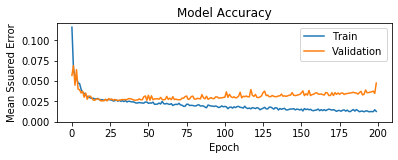

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.subplot(211)
plt.plot(HalfIncep.history['mean_squared_error'])
plt.plot(HalfIncep.history['val_mean_squared_error'])
plt.title('Model Accuracy')
plt.ylabel('Mean Ssuared Error')
plt.xlabel('Epoch')
plt.yticks([0,0.025,0.05,0.075,0.1])
plt.legend(['Train', 'Validation'], loc='upper right')
plt.rcParams["figure.figsize"] = (100,20)
plt.savefig('MetaData/'+'SiIncepLstmMSR.png')
plt.show()

In [66]:
from keras.models import load_model
import time
from numpy import array

time1=[]

temp=time.time()
mod1=load_model('MetaData/'+'SiILstmModel1.model',custom_objects ={'ManDist': ManDist})
print('Model 1 loading time:',time.time()-temp)

for i in range(10):
    temp=time.time()
    prediction=mod1.predict([array([x1[i]]),array([x2[i]])])
    time1.append(time.time()-temp)
print('avg time',sum(time1)/len(time1))
print(time1)
print('\nExcluding first prediction :' , sum(time1[1:])/len(time1[1:]),'\n',time1[1:])

Model 1 loading time: 12.827860832214355
avg time 0.5277937412261963
[4.815663576126099, 0.05691170692443848, 0.049921512603759766, 0.049920082092285156, 0.04992318153381348, 0.05191683769226074, 0.050919532775878906, 0.050920963287353516, 0.05191850662231445, 0.049921512603759766]

Excluding first prediction : 0.05136375957065158 
 [0.05691170692443848, 0.049921512603759766, 0.049920082092285156, 0.04992318153381348, 0.05191683769226074, 0.050919532775878906, 0.050920963287353516, 0.05191850662231445, 0.049921512603759766]


In [67]:
time2=[]
temp=time.time()
mod2=load_model('MetaData/'+'SiILstmModel2.h5',custom_objects ={'ManDist': ManDist})
print('Model 2 loading time:',time.time()-temp)

for i in range(10):
    temp=time.time()
    prediction=mod2.predict([array([x1[i]]),array([x2[i]])])
    time2.append(time.time()-temp)
print('avg time',sum(time2)/len(time2))
print(time2)
print('Excluding first prediction :' , sum(time2[1:])/len(time2[1:]),'\n',time2[1:])

Model 2 loading time: 18.436408519744873
avg time 0.6798372507095337
[6.3480751514434814, 0.04992389678955078, 0.04992079734802246, 0.04992389678955078, 0.04991769790649414, 0.049924373626708984, 0.048922061920166016, 0.050922393798828125, 0.04992079734802246, 0.05092144012451172]
Excluding first prediction : 0.05003303951687283 
 [0.04992389678955078, 0.04992079734802246, 0.04992389678955078, 0.04991769790649414, 0.049924373626708984, 0.048922061920166016, 0.050922393798828125, 0.04992079734802246, 0.05092144012451172]


In [68]:
time3=[]
temp=time.time()
json_file = open("MetaData/"+"SiILstmModel3.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json,custom_objects ={'ManDist': ManDist})
# load weights into new model
loaded_model.load_weights('MetaData/'+'SiILstmModel4.h5')
mod3=loaded_model
mod3.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['accuracy','mean_squared_error','mean_absolute_percentage_error'])
print('Model 3 loading time:',time.time()-temp)

for i in range(10):
    temp=time.time()
    prediction=mod3.predict([array([x1[i]]),array([x2[i]])])
    time3.append(time.time()-temp)
print('avg time',sum(time3)/len(time3))
print(time3)
print('Excluding first prediction :' , sum(time3[1:])/len(time3[1:]),'\n',time3[1:])

Model 3 loading time: 2.0525119304656982
avg time 0.52852303981781
[4.8179614543914795, 0.05092215538024902, 0.050920963287353516, 0.05191850662231445, 0.050920724868774414, 0.05291604995727539, 0.052916765213012695, 0.051918983459472656, 0.051918983459472656, 0.05291581153869629]
Excluding first prediction : 0.05191877153184679 
 [0.05092215538024902, 0.050920963287353516, 0.05191850662231445, 0.050920724868774414, 0.05291604995727539, 0.052916765213012695, 0.051918983459472656, 0.051918983459472656, 0.05291581153869629]


In [69]:
time4=[]
temp=time.time()
yaml_file = open("MetaData/"+"SiILstmModel5.yaml", 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
loaded_model = model_from_yaml(loaded_model_yaml,custom_objects ={'ManDist': ManDist})
# load weights into new model
loaded_model.load_weights("MetaData/"+"SiILstmModel6.h5")
mod4=loaded_model
print('Model 3 loading time:',time.time()-temp)

for i in range(10):
    temp=time.time()
    prediction=mod4.predict([array([x1[i]]),array([x2[i]])])
    time4.append(time.time()-temp)
    
print('avg time',sum(time4)/len(time4))
print(time4)
print('Exclusing firs val:',sum(time4[1:])/len(time4[1:]))
print('Excluding first prediction :' , sum(time4[1:])/len(time4[1:]),'\n',time4[1:])

Model 3 loading time: 2.2731690406799316
avg time 0.5581371545791626
[4.873483896255493, 0.09185528755187988, 0.06989097595214844, 0.053913116455078125, 0.09784698486328125, 0.14577460289001465, 0.0808706283569336, 0.05790901184082031, 0.05791306495666504, 0.05191397666931152]
Exclusing firs val: 0.07865418328179254
Excluding first prediction : 0.07865418328179254 
 [0.09185528755187988, 0.06989097595214844, 0.053913116455078125, 0.09784698486328125, 0.14577460289001465, 0.0808706283569336, 0.05790901184082031, 0.05791306495666504, 0.05191397666931152]
